In [1]:
# importing required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read text file into pandas DataFrame
df = pd.read_csv("ParkingDataDataset.txt", sep="\t")

In [3]:
cleaned_df = df.copy()

# dropping useless columns
cleaned_df.drop('Car ID', inplace=True, axis=1)
cleaned_df.drop('Unnamed: 27', inplace=True, axis=1)
# cleaned_df.drop('VType', inplace=True, axis=1)

# dropping useless rows
cleaned_df.drop(cleaned_df[cleaned_df['tFree'] == 0].index, inplace = True)
cleaned_df.drop(cleaned_df[cleaned_df['EntMin'] == 60] .index, inplace = True)

In [4]:
# creating datetime index column
cleaned_df['datetime'] = cleaned_df.iloc[:, 0]
cleaned_df.datetime = pd.to_datetime(cleaned_df.datetime)
cleaned_df.set_index(cleaned_df.datetime)
print('Index Column Created!')

Index Column Created!


In [5]:
# Sorting the data
cleaned_df = cleaned_df.sort_values(by=['Day', 'EntHr'], ascending=[True, True])

In [6]:
# creating new dataframe for model input
bill_df = cleaned_df.drop(cleaned_df.loc[:, cleaned_df.columns != "TBill"], axis=1)
# bill_df['datetime'] = cleaned_df.datetime
bill_df.set_index(cleaned_df.datetime, inplace=True)
bill_df

,TBill
datetime,
2022-01-01 08:25:00,8
2022-01-01 08:25:00,39
2022-01-01 08:39:00,48
2022-01-01 08:55:00,21
2022-01-01 08:49:00,52
...,...
2022-01-07 19:39:00,18
2022-01-07 19:51:00,0
2022-01-07 19:55:00,0


In [7]:
# aggregate
ts = bill_df['TBill'].resample('H').sum()
ts = ts.to_frame()

<AxesSubplot:xlabel='datetime'>

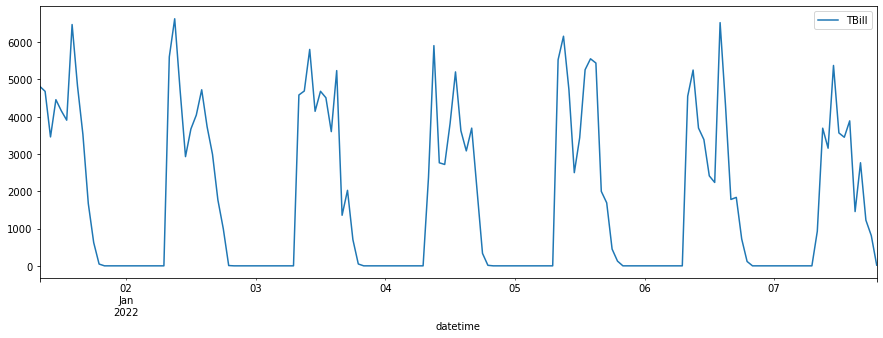

In [8]:
# plotting the aggregated series
ts.plot(figsize=(15, 5))

In [9]:
# Testing For Stationarity
from statsmodels.tsa.stattools import adfuller

# Ho: It is non stationary
# H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(ts)

ADF Test Statistic : -7.1029815348483165
p-value : 4.122020527079981e-10
#Lags Used : 14
Number of Observations Used : 141
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [10]:
new_ts = ts.copy()
new_ts

,TBill
datetime,
2022-01-01 08:00:00,4818
2022-01-01 09:00:00,4682
2022-01-01 10:00:00,3459
2022-01-01 11:00:00,4458
2022-01-01 12:00:00,4160
...,...
2022-01-07 15:00:00,1456
2022-01-07 16:00:00,2766
2022-01-07 17:00:00,1225


### Model

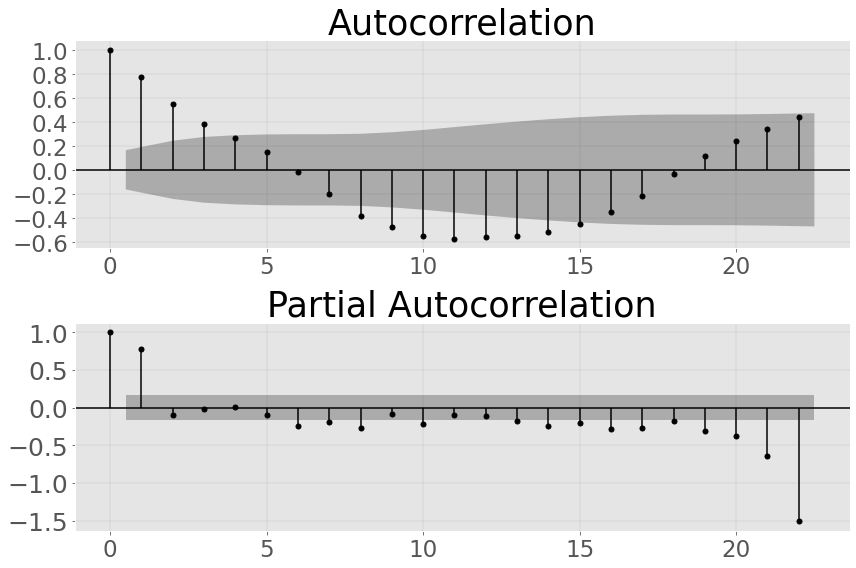

In [11]:
# selecting values of p and q
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from matplotlib.collections import PolyCollection

plt.style.use('ggplot')

my_color = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(new_ts.iloc[13:], ax=ax1, use_vlines=True, color=my_color, vlines_kwargs={"colors": my_color})

for item in ax1.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(my_color)
        
ax1.grid(which="major", color="grey", linestyle="--", linewidth=0.20)
ax1.set_title("Autocorrelation", fontsize=35)

plt.yticks(fontsize=23)
plt.xticks(fontsize=23)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(new_ts.iloc[13:], ax=ax2, use_vlines=True, color=my_color, vlines_kwargs={"colors": my_color})

# Customising the appearance
for item in ax2.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(my_color)
        
ax2.grid(which="major", color="grey", linestyle="--", linewidth=0.20)
ax2.set_title("Partial Autocorrelation", fontsize=35)

plt.yticks(fontsize=25)
plt.xticks(fontsize=23)

fig.tight_layout()
plt.savefig('foo.png', bbox_inches='tight')

In [12]:
# fitting the model
model = sm.tsa.statespace.SARIMAX(ts['TBill'], order=(1,1,0), seasonal_order=(0,1,1,24))
results = model.fit()

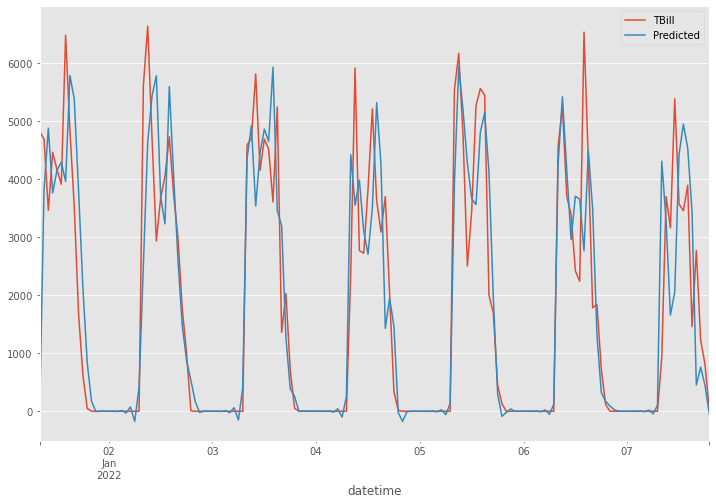

In [13]:
# getting predictions on training set
predicted_ts = results.predict(new_ts.index[0], new_ts.index[-1])

# visualizing accuracy of the model on training data
new_ts.plot(figsize=(12,8), label='Actual')
predicted_ts.plot(figsize=(12,8), label='Predicted')
plt.legend()
plt.show()

### Extrapolating

In [14]:
# The following code generates future timestamps after
# the timestamp of last training sample present in out data
# set, hence the aggregation of term 'new_ts.index[-1]' in 2nd line .

# The value 0-29 in range suggest that we are extrapolating for next 29 hours, i.e., from 
# 7 July, 7 pm TO 8 July, 11:59 pm(29 hours)

from pandas.tseries.offsets import DateOffset
future_dates=[new_ts.index[-1]+ DateOffset(hours=x)for x in range(0,29)]
future_dates

[Timestamp('2022-01-07 19:00:00', freq='H'),
 Timestamp('2022-01-07 20:00:00', freq='H'),
 Timestamp('2022-01-07 21:00:00', freq='H'),
 Timestamp('2022-01-07 22:00:00', freq='H'),
 Timestamp('2022-01-07 23:00:00', freq='H'),
 Timestamp('2022-01-08 00:00:00', freq='H'),
 Timestamp('2022-01-08 01:00:00', freq='H'),
 Timestamp('2022-01-08 02:00:00', freq='H'),
 Timestamp('2022-01-08 03:00:00', freq='H'),
 Timestamp('2022-01-08 04:00:00', freq='H'),
 Timestamp('2022-01-08 05:00:00', freq='H'),
 Timestamp('2022-01-08 06:00:00', freq='H'),
 Timestamp('2022-01-08 07:00:00', freq='H'),
 Timestamp('2022-01-08 08:00:00', freq='H'),
 Timestamp('2022-01-08 09:00:00', freq='H'),
 Timestamp('2022-01-08 10:00:00', freq='H'),
 Timestamp('2022-01-08 11:00:00', freq='H'),
 Timestamp('2022-01-08 12:00:00', freq='H'),
 Timestamp('2022-01-08 13:00:00', freq='H'),
 Timestamp('2022-01-08 14:00:00', freq='H'),
 Timestamp('2022-01-08 15:00:00', freq='H'),
 Timestamp('2022-01-08 16:00:00', freq='H'),
 Timestamp

In [15]:
# Converting above series to DataFrame
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=new_ts.columns)
future_datest_df

,TBill
2022-01-07 20:00:00,NaN
2022-01-07 21:00:00,NaN
2022-01-07 22:00:00,NaN
2022-01-07 23:00:00,NaN
2022-01-08 00:00:00,NaN
2022-01-08 01:00:00,NaN
2022-01-08 02:00:00,NaN
2022-01-08 03:00:00,NaN
2022-01-08 04:00:00,NaN
2022-01-08 05:00:00,NaN


In [16]:
# Appending the above dataframe at the end of our original dataframe
new_ts=pd.concat([new_ts,future_datest_df])
(new_ts)

,TBill
2022-01-01 08:00:00,4818
2022-01-01 09:00:00,4682
2022-01-01 10:00:00,3459
2022-01-01 11:00:00,4458
2022-01-01 12:00:00,4160
...,...
2022-01-08 19:00:00,NaN
2022-01-08 20:00:00,NaN
2022-01-08 21:00:00,NaN
2022-01-08 22:00:00,NaN


,TBill
2022-01-01 08:00:00,4818
2022-01-01 09:00:00,4682
2022-01-01 10:00:00,3459
2022-01-01 11:00:00,4458
2022-01-01 12:00:00,4160
2022-01-01 13:00:00,3908
2022-01-01 14:00:00,6474
2022-01-01 15:00:00,4826
2022-01-01 16:00:00,3527
2022-01-01 17:00:00,1671


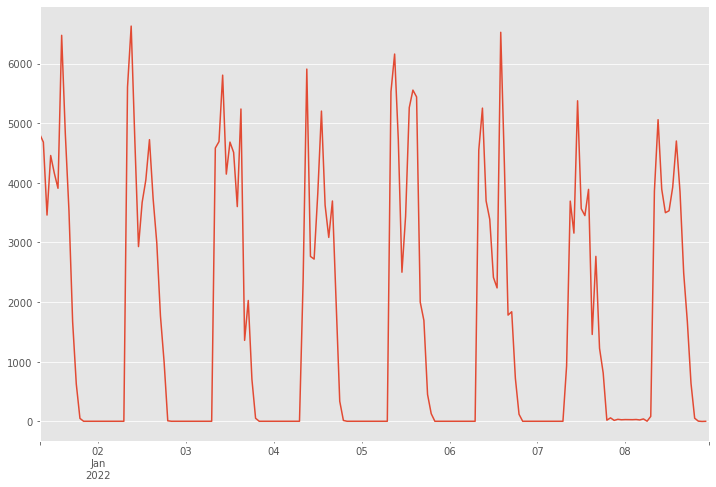

In [17]:
# getting predictions
new_ts['TBill'].iloc[156:183] = results.predict(start = 156, end = 182, dynamic= True)  
new_ts.TBill.plot(figsize=(12, 8)) 
new_ts.head(30)

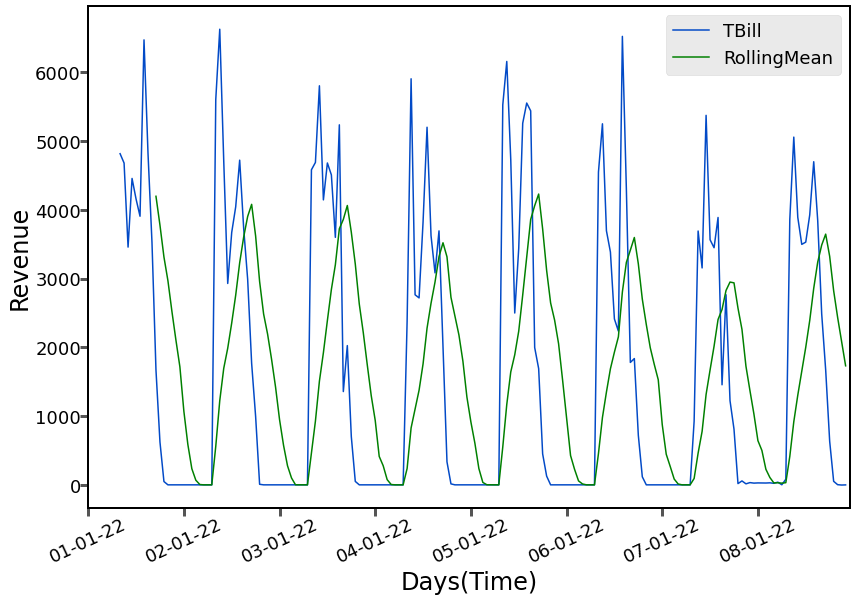

In [24]:
import datetime
plt.style.use('ggplot')

# For Rolling Mean
new_ts['RollingMean'] = new_ts.TBill.rolling(10).mean()
sd = ts.TBill.std()
mean = ts.TBill.mean()

#Plotting predictions and the previous data
fig, ax = plt.subplots(figsize=(12,8))
xticks = pd.date_range(datetime.datetime(2022,1,1), datetime.datetime(2022,1,8), freq='d')

new_ts.TBill.plot(ax=ax, figsize=(12,8), xticks=xticks.to_pydatetime(), color='#024ac7')
new_ts.RollingMean.plot(ax=ax, figsize=(12,8), xticks=xticks.to_pydatetime(), color='g', alpha=1)

# Customising appearance of plot
ax.set_xticklabels([x.strftime('%d-%m-%y') for x in xticks]);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')

for line in ax.yaxis.get_ticklines():
    line.set_markersize(8)
    line.set_markeredgewidth(3)
for line in ax.xaxis.get_ticklines():
    line.set_markersize(8)
    line.set_markeredgewidth(3)
ax.set_facecolor('white')


plt.yticks(fontsize=18, color='black')
plt.xticks(fontsize=18, color='black')
plt.xlabel("Days(Time)", fontsize=24, color='black')
plt.ylabel("Revenue", fontsize=24, color='black')

leg = plt.legend(fontsize=18, loc = "upper right")
for text in leg.get_texts():
    text.set_color("black")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.xticks(rotation = 25)
plt.grid(False)

plt.savefig('predictions.png', bbox_inches='tight', format='png', facecolor='w')
plt.show()